In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/23_1_인지프/models/LSTM')

In [2]:
!pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29088 sha256=64597795867d3c3d70831a0b8fc6bcd758bd45d2deae53ec0623c35f8a6e448f
  Stored in directory: /root/.cache/pip/wheels/47/51/06/380dc516ea78621870b93ff65527c251afdfdc5fa9d7f4d248
Successfully built ta


In [161]:
#call library

import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import math
import ta


In [170]:
def makeY(folder_name, filelength):

    if folder_name=='growth':
        yGrowths = np.ones(filelength)
        yValues = np.zeros(filelength)
    elif folder_name=='value':
        yGrowths = np.zeros(filelength)
        yValues = np.ones(filelength)
    elif folder_name=='overlap':
        yGrowths = np.ones(filelength)
        yValues = np.ones(filelength)

    y = np.column_stack([yGrowths.T, yValues.T])
    return y


def preprocess_for_EDA(folder_name):
   # set file path
    folder_path = f'/content/drive/MyDrive/research/data/{folder_name}_clean'

    # load file name in folder
    file_names = os.listdir(folder_path)
    data_array = []

    for file in file_names:
        # set file path
        file_path = os.path.join(folder_path, file)
        
        # load csv file as dataframe
        df = pd.read_csv(file_path, index_col=0)
        df.index = pd.to_datetime(df.index)

        #preprocessing column
        # df['open-close'] = df['Open'] - df['Close'] #추가
        df['Open-shift'] = df['Open'].shift(1)
        # df = df[1:,:,:]
        df = df.iloc[1:,:]

        df['open-close'] = df['Open-shift'] - df['Close']
        df['open-close'] = df['open-close'] + abs(min(df['open-close'])) #추가
        df['MA5'] = df['Close'].rolling(5).mean() #추가
        df['Diff'] = df['High'] - df['Low']
        df['RSI'] = ta.momentum.rsi(df['Close'])
        df['MACD'] = ta.trend.macd(df['Close'])


        df = df[['Close','Volume','Diff','open-close','MA5', 'Search','MACD','RSI']]
        df.fillna(0,inplace=True)

        #log transform
        # df = np.log1p(df)
        
        # df.reset_index(inplace=True)
        df.fillna(0,inplace=True)
        
        # scaler = MinMaxScaler()
        scaler = StandardScaler()
        df = scaler.fit_transform(df)

        #insert list to array
        data_array.append(df)

    return np.array(data_array)

In [171]:
xGrowths = preprocess_for_EDA('growth')
xValues = preprocess_for_EDA('value')
# xOverlaps = preprocess_for_EDA('overlap')

In [172]:
#bootstrap
n_samples = len(xValues)
diff = len(xValues) - len(xGrowths)
xGrowths_bootstrapped = xGrowths[np.random.choice(len(xGrowths), size=diff, replace=True)]
xGrowths = np.concatenate((xGrowths, xGrowths_bootstrapped), axis=0)

# diff = len(xValues) - len(xOverlaps)
# xOverlaps_bootstrapped = xOverlaps[np.random.choice(len(xOverlaps), size=diff, replace=True)]
# xOverlaps = np.concatenate((xOverlaps, xOverlaps_bootstrapped), axis=0)

In [173]:
#make y values
yGrowths = makeY('growth', n_samples)
yValues = makeY('value', n_samples)
# yOverlaps = makeY('overlap', n_samples)

In [174]:
dateindex = pd.read_csv('/content/drive/MyDrive/research/models/date.csv', header=None)
dateindex = dateindex[0][1:]
colname = ['Close','Volume','Diff','open-close','MA5', 'Search','MACD','RSI']

In [167]:
def threeDarray_to_df(x, index, colname):
  df = pd.DataFrame()
  for i in range(x.shape[0]):
    df_add = pd.DataFrame(x[i], index=index, columns=colname)
    df = pd.concat([df, df_add])
  return df

In [175]:
xGrowths_df = threeDarray_to_df(xGrowths, dateindex, colname)
xValues_df = threeDarray_to_df(xValues, dateindex, colname)
# xOverlaps_df = threeDarray_to_df(xOverlaps, dateindex, colname)

In [88]:
def draw(x, feature, color, which):

  #변수 생성
  _mean = x.groupby(by=x.index).mean()
  #0값 제거
  idx = _mean[_mean[feature]==0].index
  _mean.drop(idx, inplace=True)
  x.drop(idx, inplace=True)

  _date = x.index.unique()
  _len = len(_date) 

  #날짜별 표준편차
  _std = []
  for i in range(_len):
    date = _date[i]
    tmp = list(x[x.index == date]['{}'.format(feature)])
    tmp_mean = sum(tmp)/len(tmp)
    tmp2 = []
    for j in tmp:
        tmp2.append((j - tmp_mean)**2)
    _std.append(math.sqrt(sum(tmp2) / len(tmp)))

  #날짜별 신뢰구간
  #신뢰도 95% 사용
  _reliability = []
  for i in _std:
      _reliability.append(1.96 * i / math.sqrt(len(tmp)))

  #윗부분 아랫부분 따로 연산
  upper_ci = []
  lower_ci = []
  for i in range(len(_mean)):
      upper_ci.append(_mean['{}'.format(feature)][i] + _reliability[i])
      lower_ci.append(_mean['{}'.format(feature)][i] - _reliability[i])

  # 도화지
  fig, ax = plt.subplots()
  fig.set_size_inches(20, 5)

  # 신뢰구간
  ax.fill_between(pd.to_datetime(_date), upper_ci, lower_ci, facecolor=color, interpolate=True, alpha = 0.2)

  # 평균
  ax.plot(pd.to_datetime(_date), _mean['{}'.format(feature)], color)

  # x축, y축 제목
  ax.set_xlabel('date')
  ax.set_ylabel('{}'.format(feature))

  ax.set_title('{} Stock {}'.format(which, feature))
  #ax.set_ylim(0.0, 0.9)

  plt.grid()
  plt.show()

## 8 features

In [19]:
for col in colname:
  draw(xGrowths_df, col, 'green', 'Growth')

Close
Volume
Diff
open-close
MA5
Search
MACD
RSI


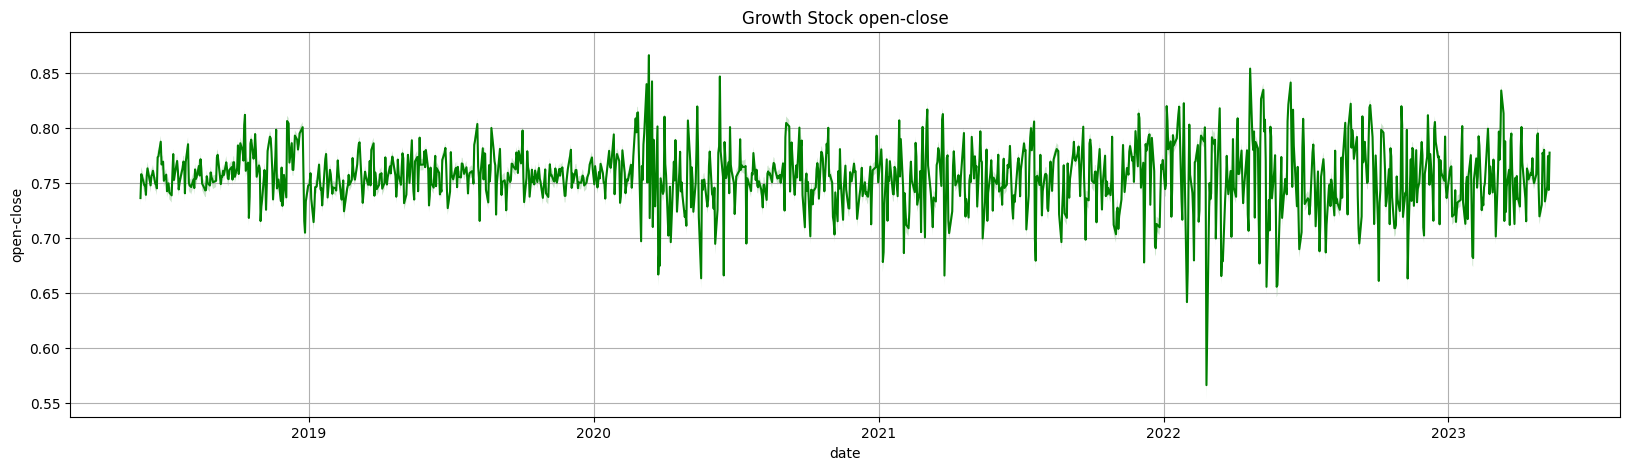

In [158]:
draw(xGrowths_df, 'open-close', 'green', 'Growth')

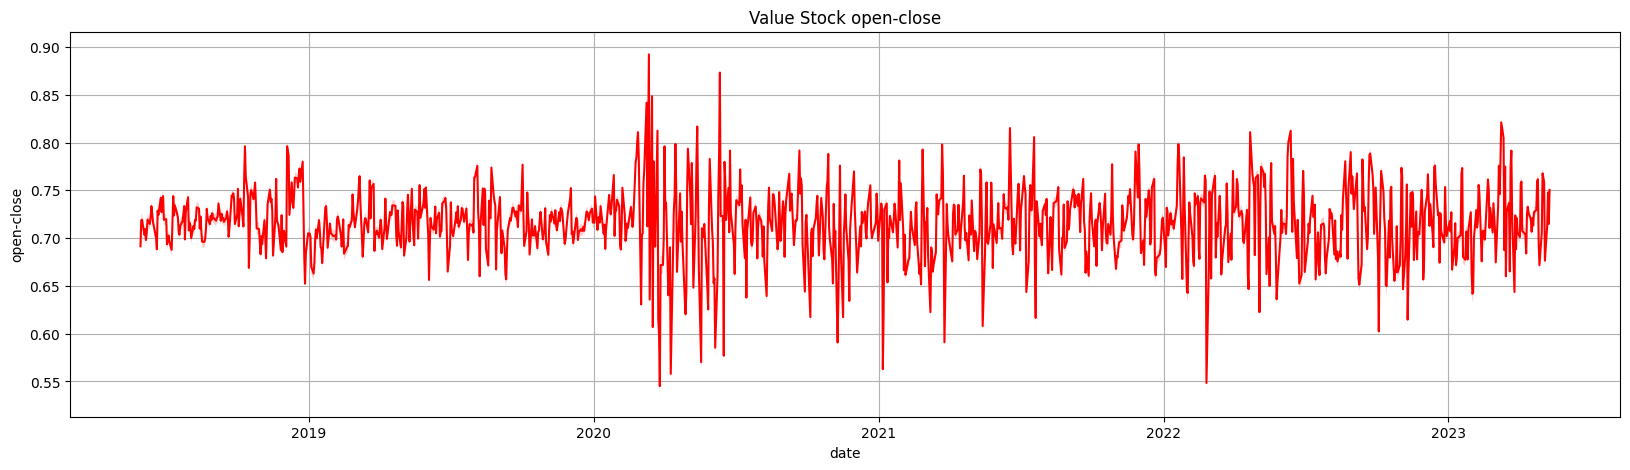

In [160]:
draw(xValues_df, 'open-close', 'red', 'Value')

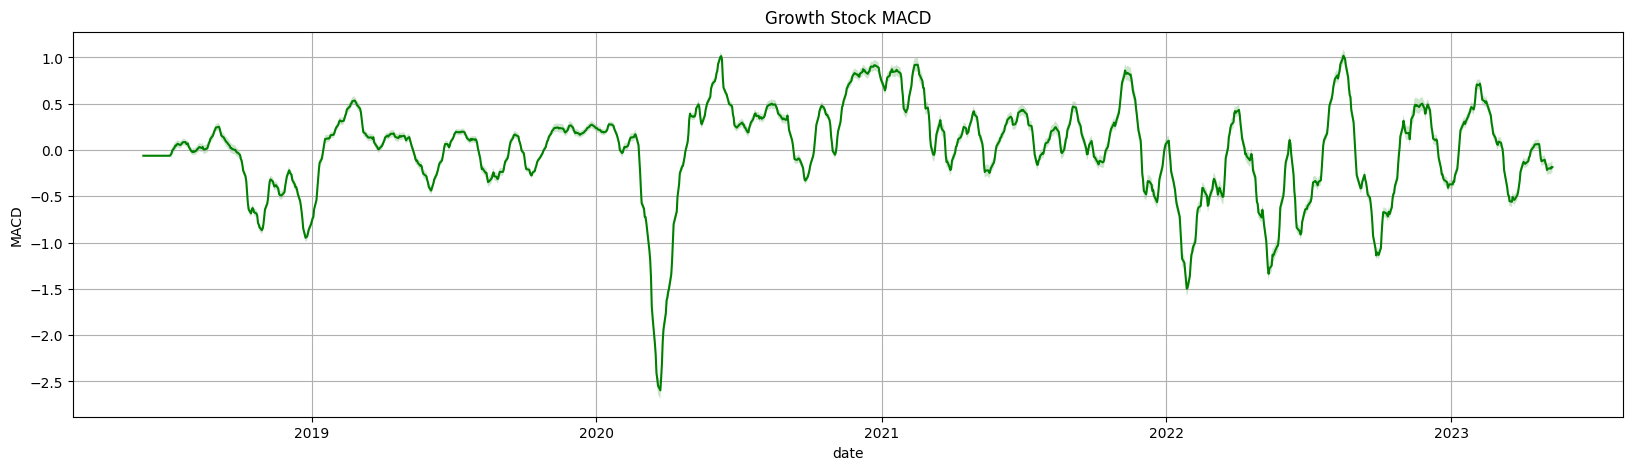

In [176]:
draw(xGrowths_df, 'MACD', 'green', 'Growth')

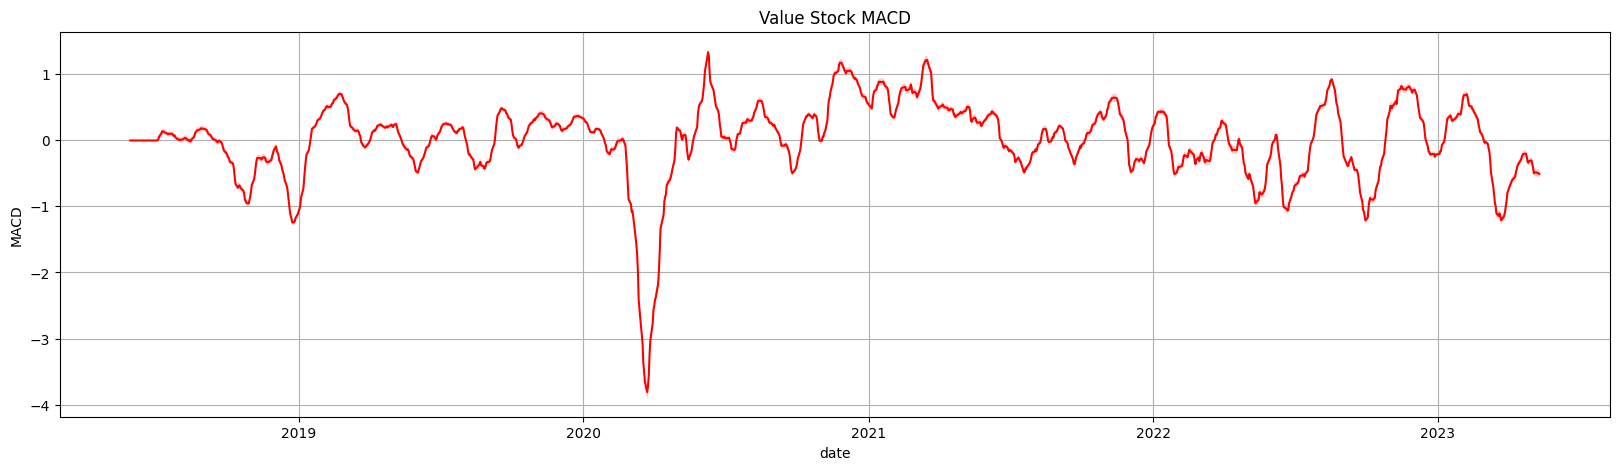

In [177]:
draw(xValues_df, 'MACD', 'red', 'Value')

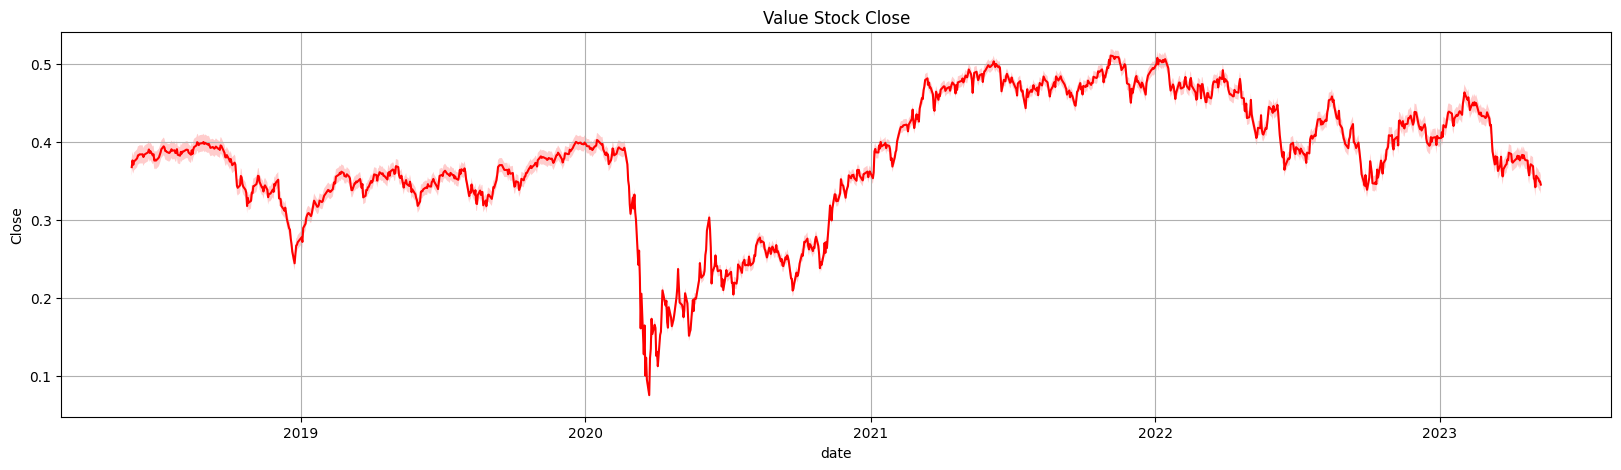

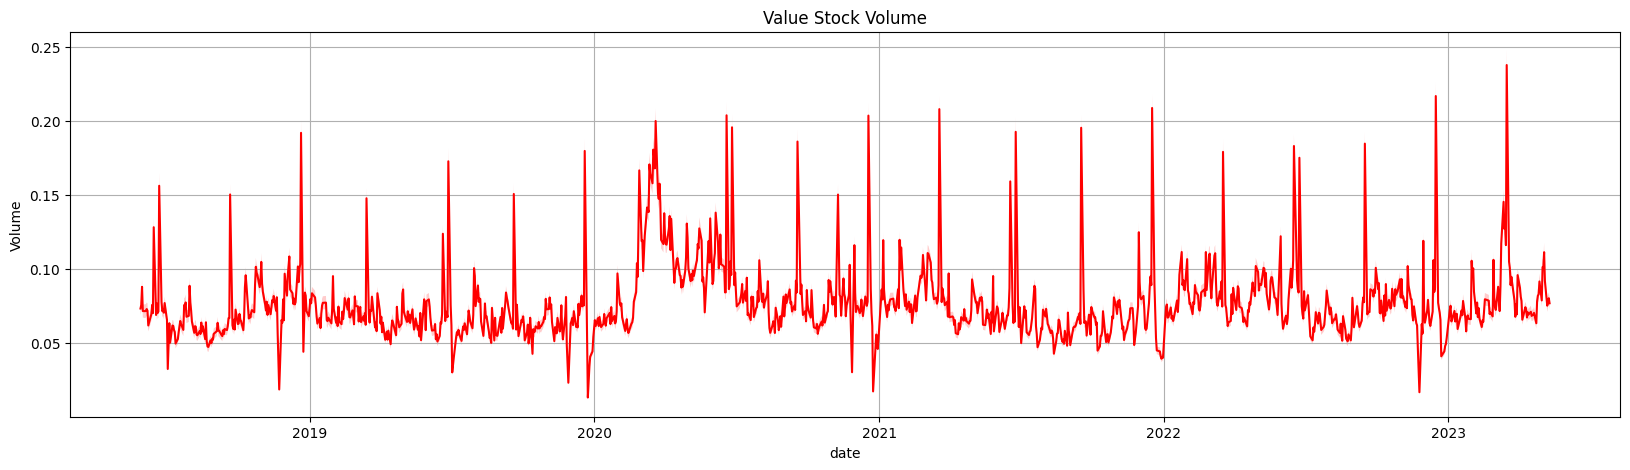

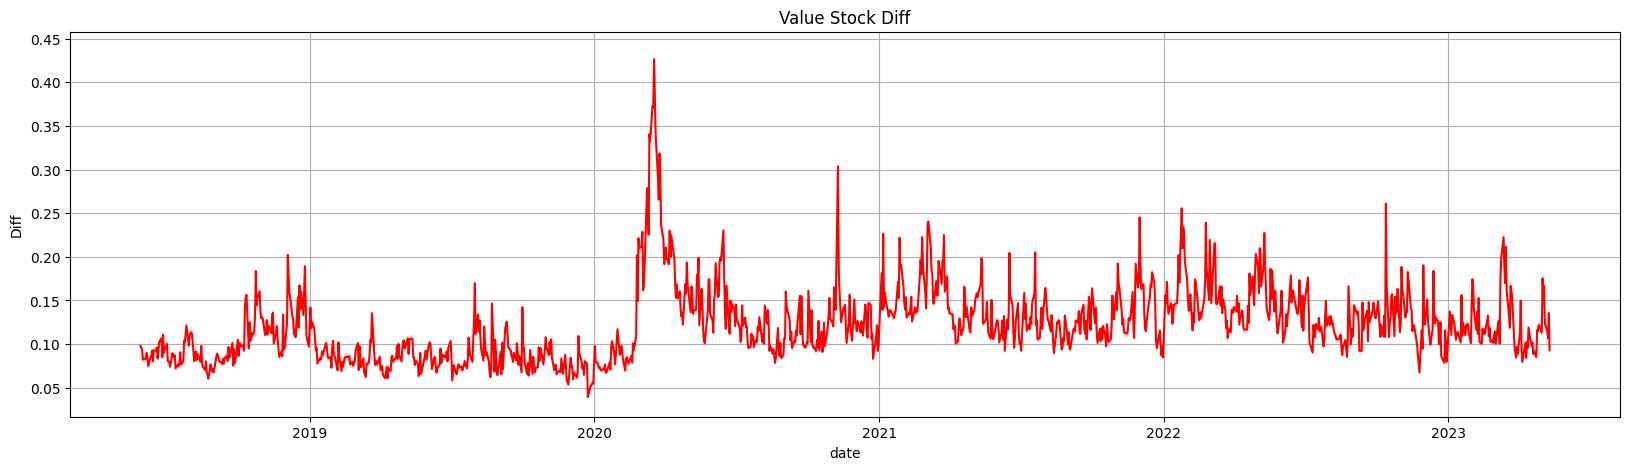

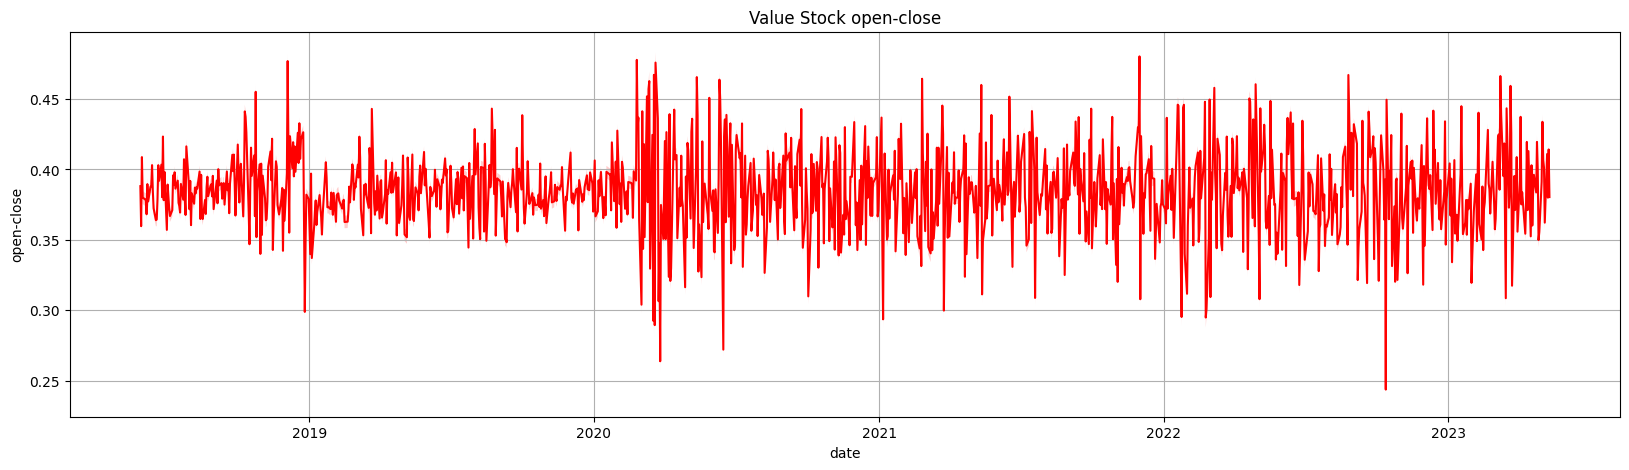

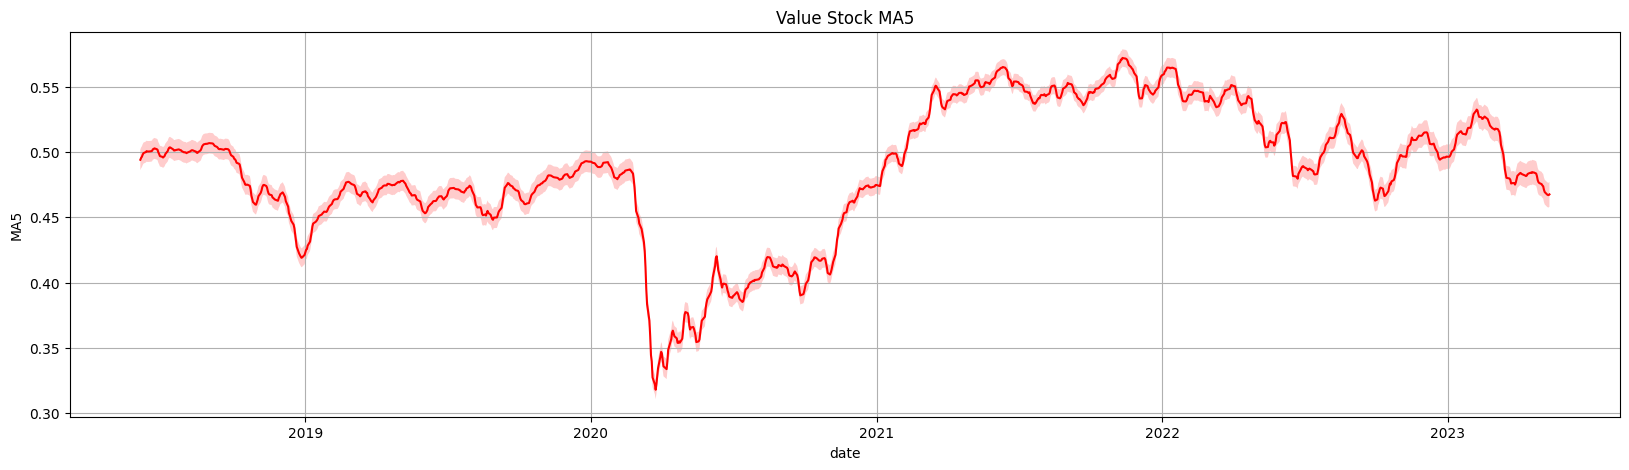

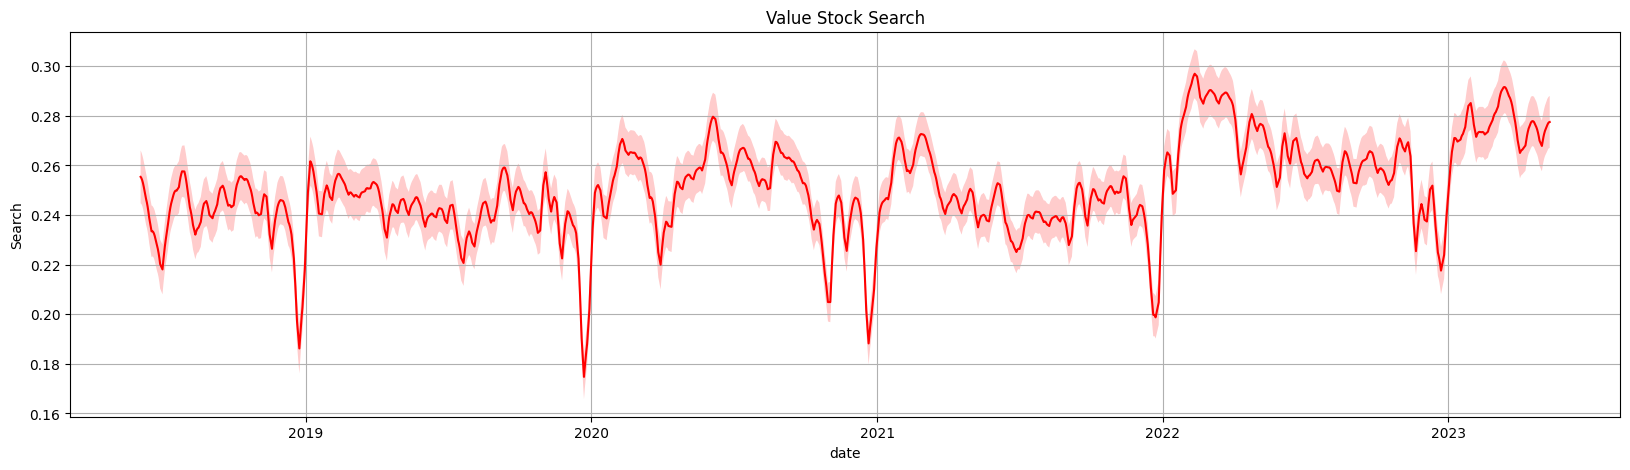

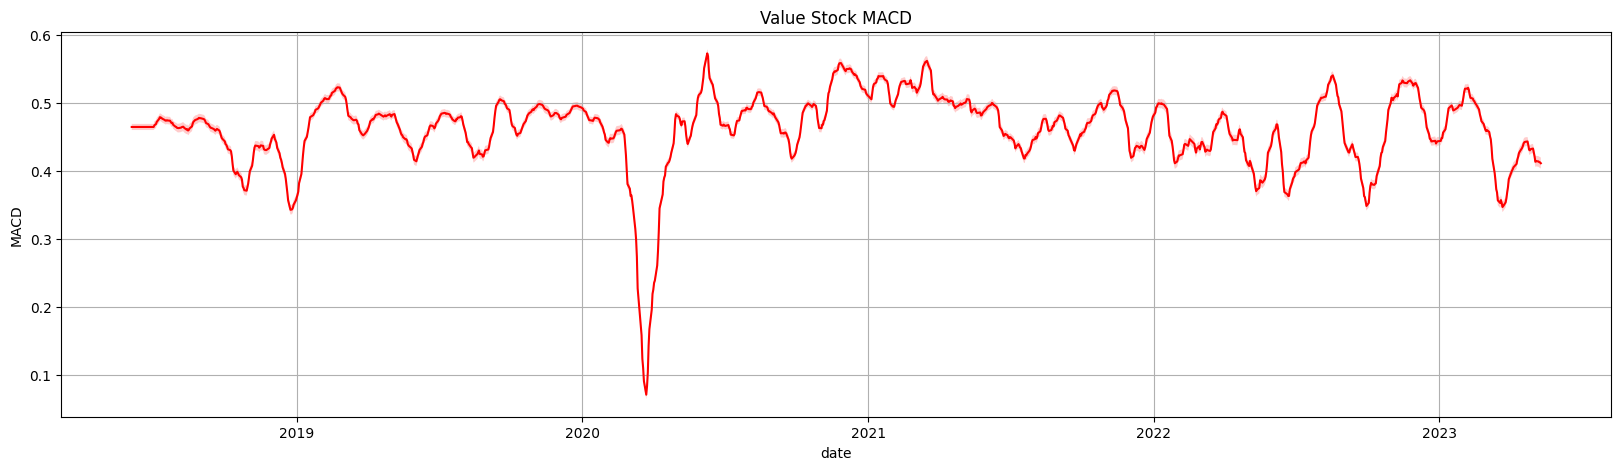

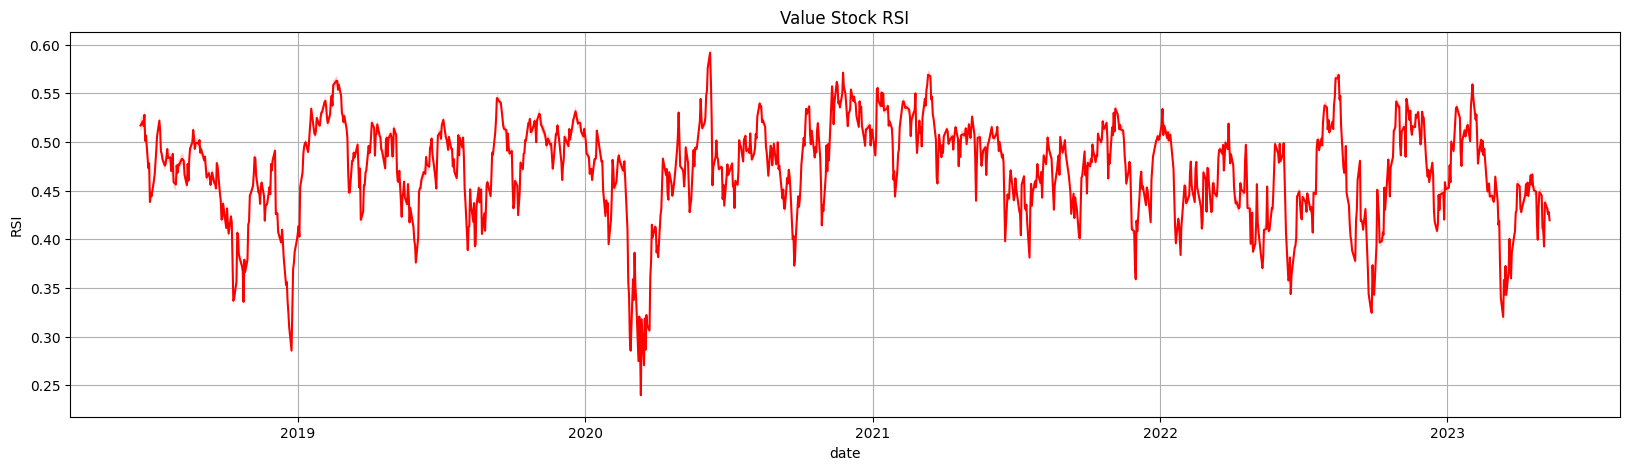

In [ ]:
for col in colname:
  draw(xValues_df, col, 'red', 'Value')

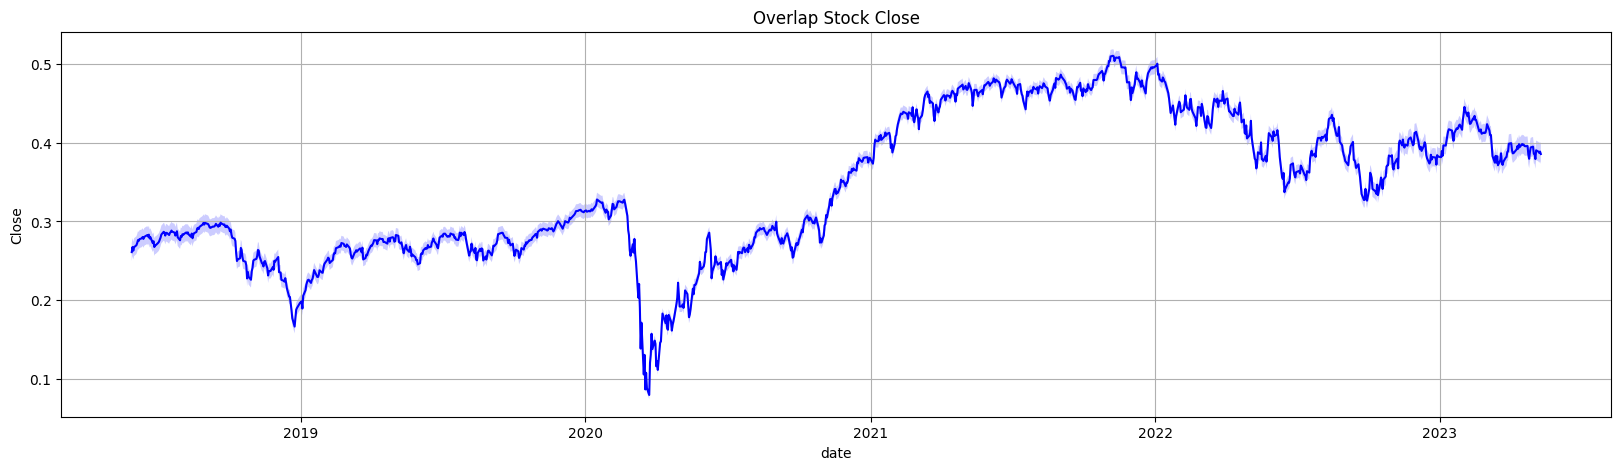

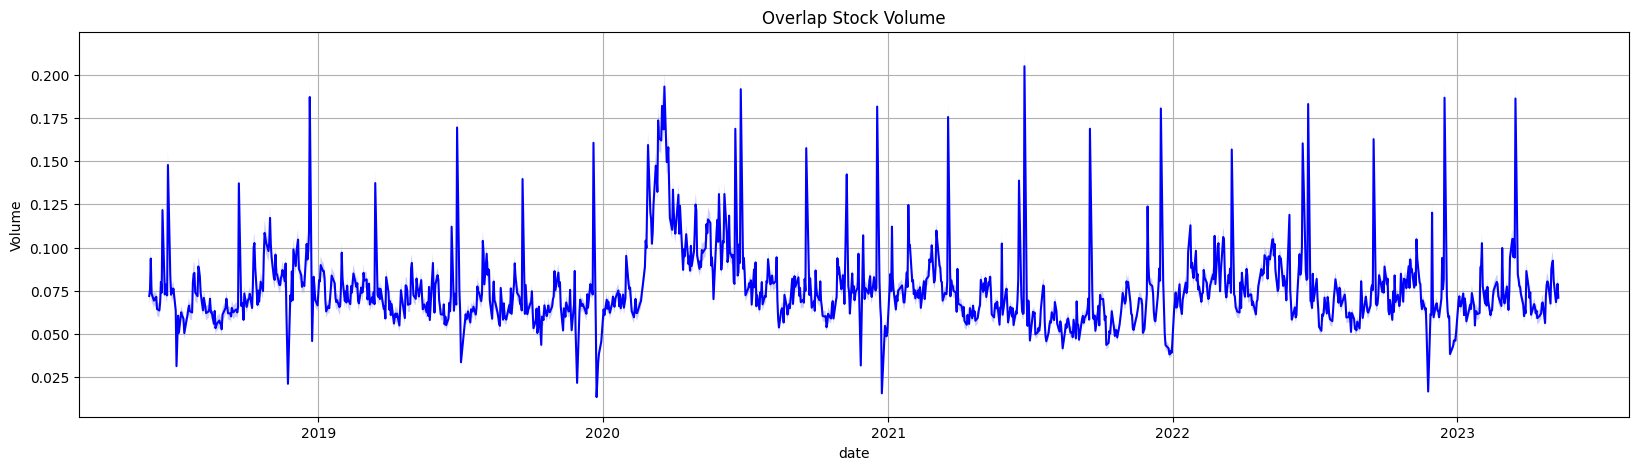

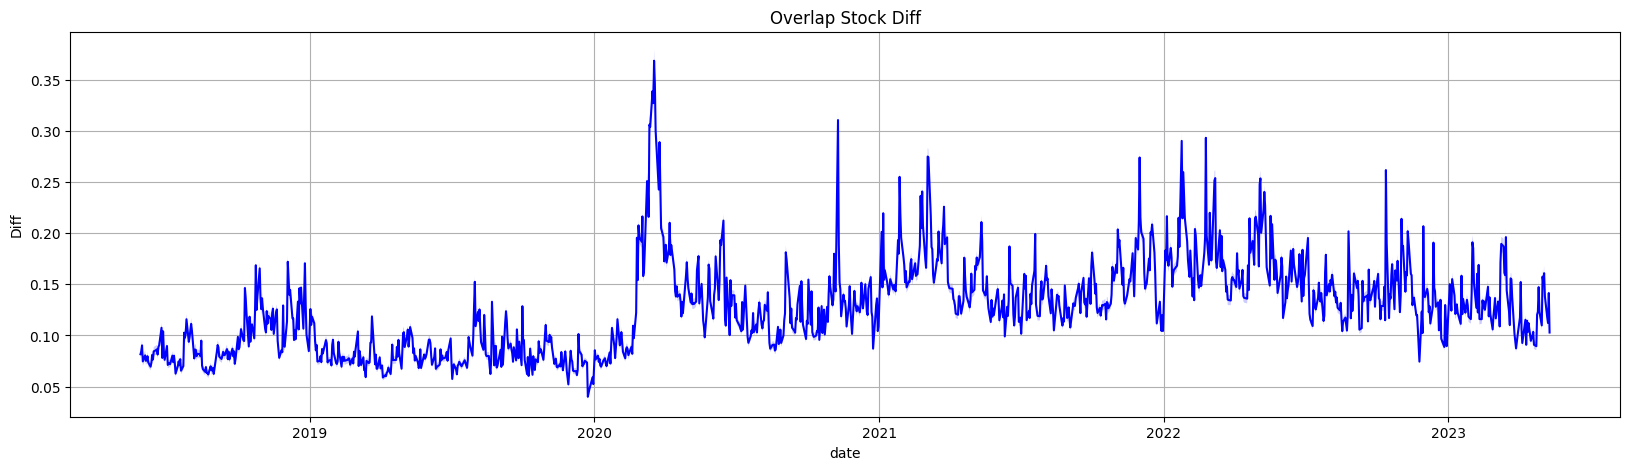

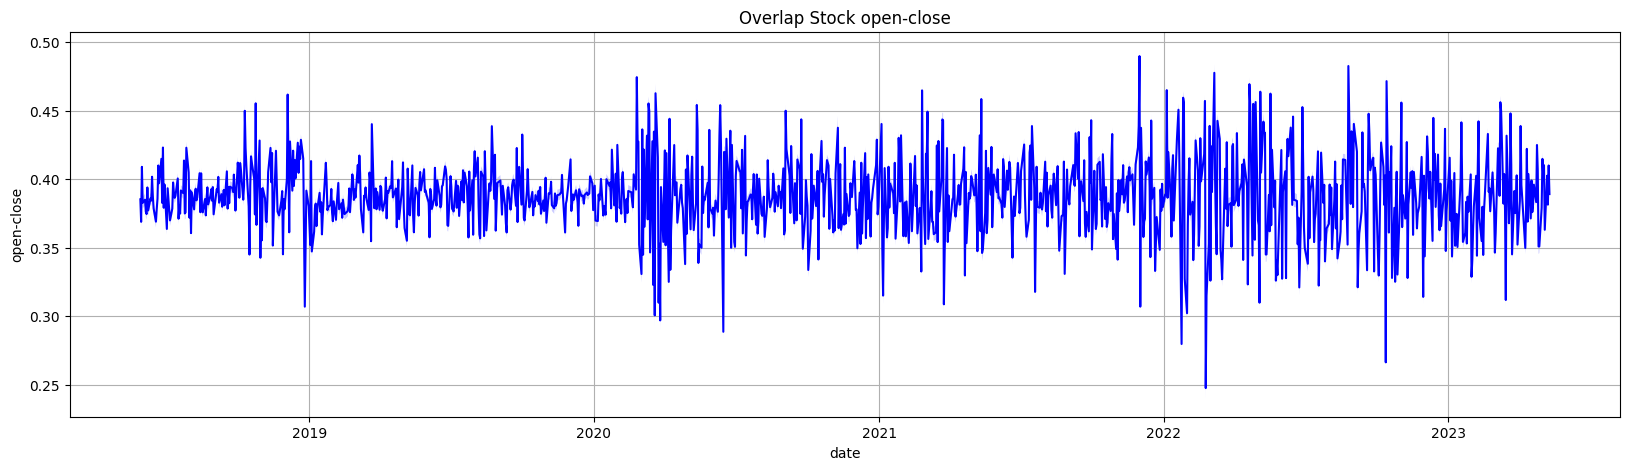

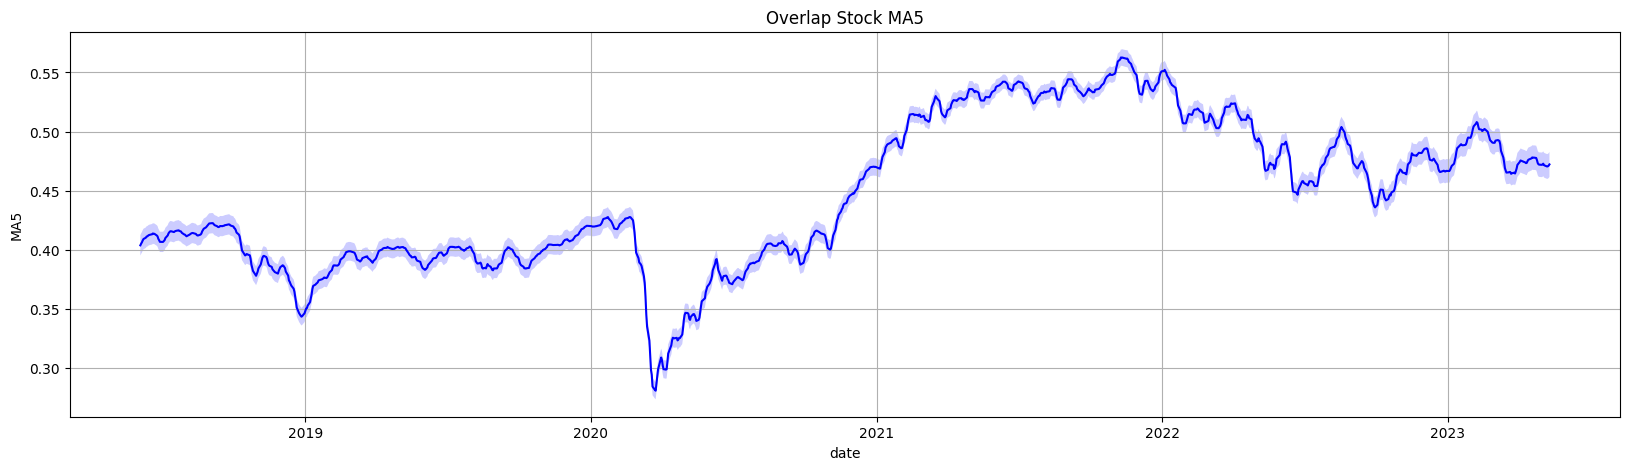

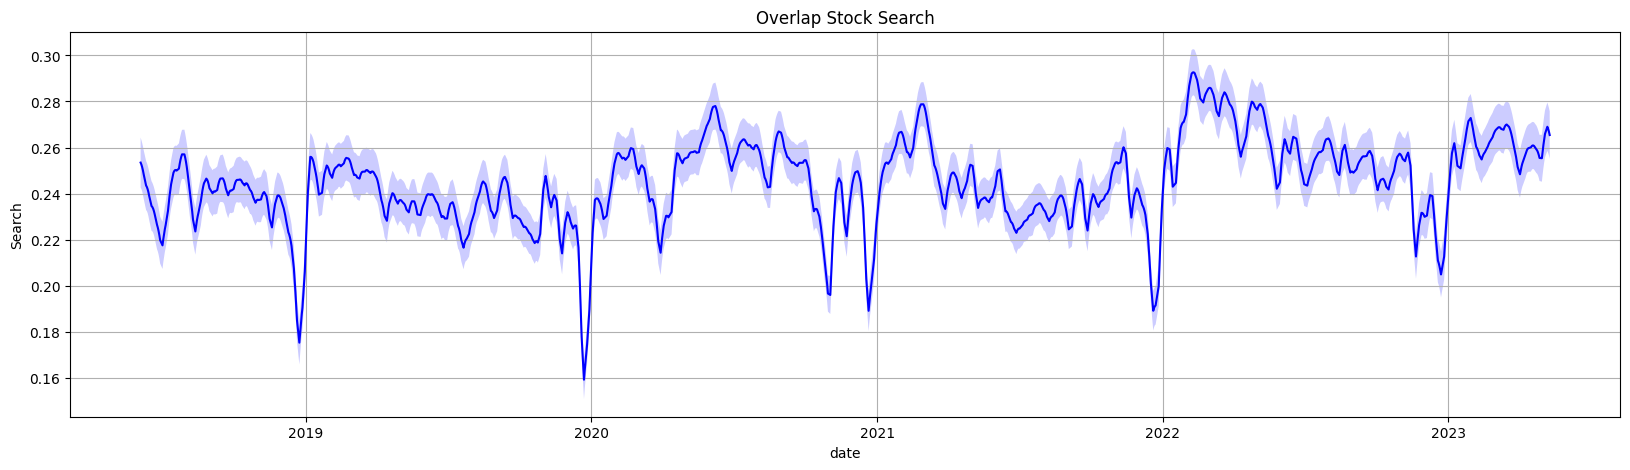

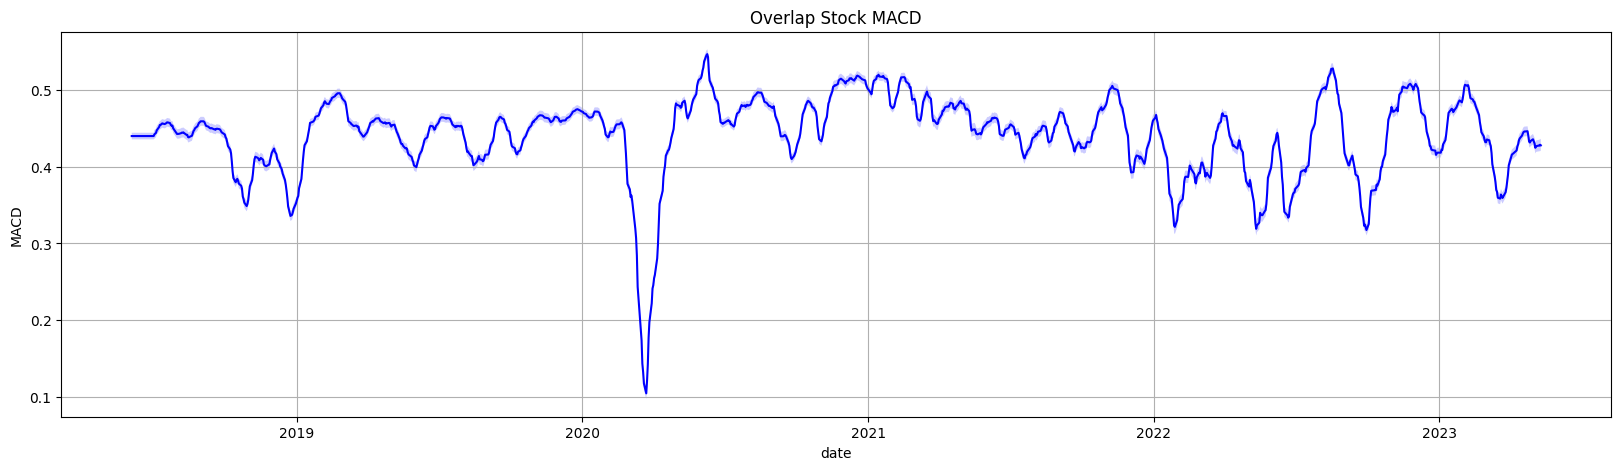

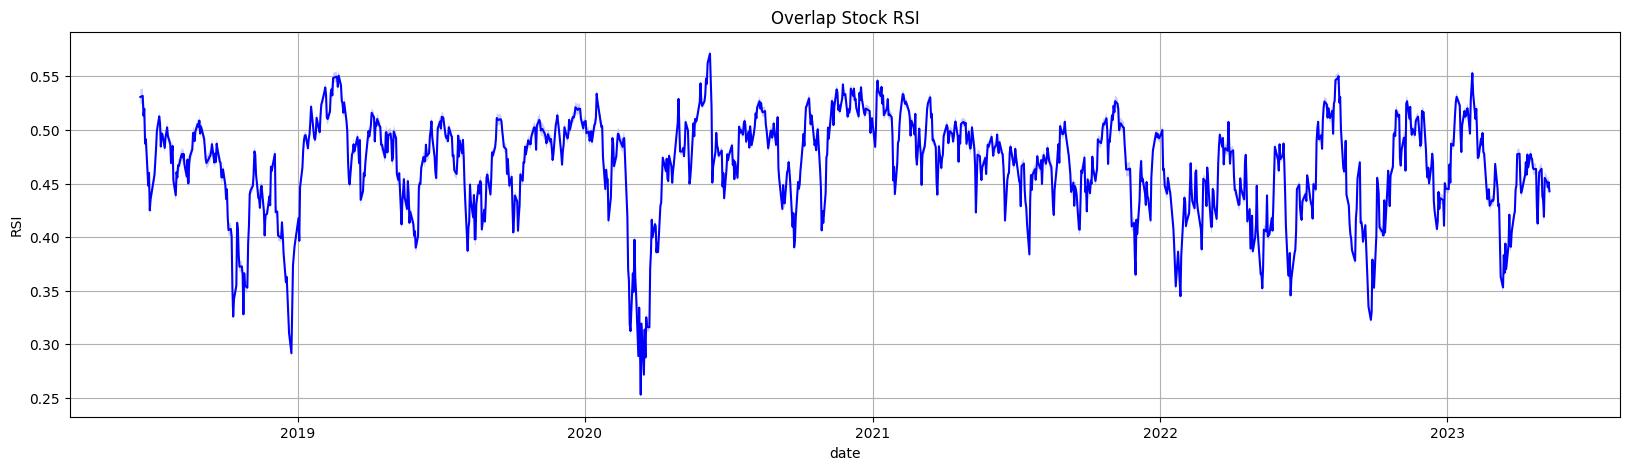

In [ ]:
for col in colname:
  draw(xOverlaps_df, col, 'blue', 'Overlap')